## 배터리 최적화(휴리스틱)

### 데이터 전처리

In [6]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd

# .mat 파일 로드

data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)
clearDay = data['clearDay'].flatten().reshape(-1, 1)
loadData = data['loadData'][:, 2].reshape(-1, 1) * 10e-5
costData = data['costData'].flatten().reshape(-1, 1)


print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )



자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


### 데이터 처리

In [8]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1  # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

H2ToalE = 100 * 33.33                       # 총 전력량(KW) = 수소 저장 탱크 * 1KG 당 발전량 
hydrogenStorage = 0.5 * H2ToalE             # 수소 탱크 초기 저장량 
maxSOC = 0.9 * H2ToalE                      # 수소의 최대 에너지 상태
minSOC = 0.2 * H2ToalE                      # 수소최소 허용 에너지 상태
Pmin = -400e3                               # 에너지가 수소로부터 방출
Pmax = 400e3                                # 에너지가 수고로 저장 

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))
clearPpv = 1 * 1 * np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1))

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt



/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_77915/628246337.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))


In [31]:
import numpy as np
from scipy.optimize import linprog

def lp_optimization(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time):
    # 변수 초기화
    n = len(Pload)
    Pgrid = np.zeros(n)
    Phydro = np.zeros(n)
    
    # 시간대 정의
    medium_hours = [(28800 <= t < 39600) or (43200 <= t < 46800) or (64800 <= t < 68400) for t in time]
    heavy_hours = [(39600 <= t < 43200) or (46800 <= t < 64800) for t in time]
    light_hours = [(t >= 79200) or (t < 28800) for t in time]

    # 목적 함수: Pgrid를 최소화 (수소 저장 에너지 비용과 수소 충전 비용 포함)
    c = np.zeros(2 * n)
    c[:n] = 1  # Pgrid의 계수 (최소화 대상)
    c[n:] = 0  # Phydro의 계수 (최소화 대상이 아님)

    # 제약 조건 설정
    A = []
    b = []

    for i in range(n):
        # Pload - Ppv <= Pgrid[i] - hydrogenStorage
        # 수소 에너지를 사용할 경우 제약 조건
        A.append([0] * i + [-1] + [0] * (n - i - 1) + [0] * n)
        b.append(Pload[i] - Ppv[i])

        # Pgrid[i] + hydrogenStorage >= Pload[i] - Ppv[i]
        # 태양광 에너지를 사용할 경우 제약 조건
        A.append([0] * i + [1] + [0] * (n - i - 1) + [0] * n)
        b.append(Pload[i] - Ppv[i])

        # Phydro[i] >= minSOC
        A.append([0] * n + [0] * i + [-1] + [0] * (n - i - 1))
        b.append(-minSOC)

        # Phydro[i] <= maxSOC
        A.append([0] * n + [0] * i + [1] + [0] * (n - i - 1))
        b.append(maxSOC)

    A = np.array(A)
    b = np.array(b)

    # 경계 설정
    bounds = [(Pmin, Pmax)] * n + [(minSOC, maxSOC)] * n

    # 최적화 문제 해결
    result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

    if result.success:
        Pgrid = result.x[:n]
        Phydro = result.x[n:]
    else:
        print("Optimization failed:", result.message)

    return Pgrid, Phydro

# 가상의 데이터 예시
Ppv = np.array([100, 150, 200, 250, 300])
Pload = np.array([200, 250, 300, 350, 400])
hydrogenStorage = 50
minSOC = 20
maxSOC = 80
Pmin = 0
Pmax = 500
time = np.array([30000, 35000, 40000, 45000, 50000])

Pgrid, Phydro = lp_optimization(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time)

print("Pgrid:", Pgrid)
print("Phydro:", Phydro)


Pgrid: [0.00000 0.00000 0.00000 0.00000 0.00000]
Phydro: [20.00000 20.00000 20.00000 20.00000 20.00000]


In [3]:
def rule_based_control(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time):
    Pgrid = np.zeros_like(Pload)  # 전력 그리드 초기화
    Phydro = np.zeros_like(Pload)
    
    for i in range(len(Pload)):
        # 8시~11시, 12시~13시, 18시~22시
        # Medium 시간대
        if (28800 <= time[i] < 39600 or 43200 <= time[i] < 46800 or 64800 <= time[i] < 68400) :
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                
                Pgrid[i] = tNeedPower
                Phydro[i] = hydrogenStorage

                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage

                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))

        # 11시~12시, 13시~18시
        # Heavy 시간대
        # 이때 수소 에너지 사용
        elif (39600 <= time[i] < 43200 or 46800 <= time[i] < 64800) :
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                tNeedHydroPower = tNeedPower * 2
                tPossible_Hydrogen = hydrogenStorage - minSOC # 사용 가능 수소 전력

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tNeedHydroPower, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tMoreNeedPower = tNeedHydroPower - tPowerDisChg # 충전하고 남은 전력량               
                tNeedPower = tMoreNeedPower / 2
                
                 # 배터리를 방전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerDisChg) > minSOC) and ((hydrogenStorage - tPowerDisChg) < maxSOC) :
                    hydrogenStorage -= tPowerDisChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = 0

                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    hydrogenStorage -= tPowerDisChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = tNeedPower
                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
                    
        # 22시~8시
        # Light 시간대
        elif ((time[i] >= 79200) or (time[i] < 28800)) :
            # 부하 > 태양광
            if (Pload[i] > Ppv[i]) :
                tNeedPower = Pload[i] - Ppv[i] # 필요한 전력
                
                Phydro[i] = hydrogenStorage
                Pgrid[i] = tNeedPower
                    
            # 태양광 > 부하
            else :
                tSurplusPower = Ppv[i] - Pload[i]
                H2 = ((tSurplusPower * 0.7 * 33.33) / 1000) * 33.33 # 잉여 전력 -> 수소 에너지
                tPossible_Hydrogen = maxSOC - hydrogenStorage # 충전 가능 용량

                # 수소 탱크에 충전할 전력 계산
                tPowerChg = min(H2, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                tSurplusChg = H2 - tPowerChg # 충전하고 남은 전력량

                # 배터리를 충전했을 때 20~90% 일 때
                if ((hydrogenStorage - tPowerChg) > minSOC) and ((hydrogenStorage - tPowerChg) < maxSOC) :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                # 배터리를 충전했을 때 90% 이상일 때
                else :
                    hydrogenStorage += tPowerChg
                    Phydro[i] = hydrogenStorage
                    Pgrid[i] = -(tSurplusChg / 33.33) * (1000 / (0.7 * 33.33))
                        
        print(f"{i} 전력: {hydrogenStorage} \t 그리드: {Pgrid[i]}")
    return Pgrid, Phydro


Pgrid, Phydro = rule_based_control(Ppv, Pload, hydrogenStorage, minSOC, maxSOC, Pmin, Pmax, time)

0 전력: [1668.16134] 	 그리드: [0.00000]
1 전력: [1669.09950] 	 그리드: [0.00000]
2 전력: [1669.09950] 	 그리드: [0.83575]
3 전력: [1669.09950] 	 그리드: [1.93219]
4 전력: [1669.09950] 	 그리드: [0.99139]
5 전력: [1669.09950] 	 그리드: [1.41668]
6 전력: [1669.09950] 	 그리드: [0.97139]
7 전력: [1669.09950] 	 그리드: [1.43668]
8 전력: [1669.09950] 	 그리드: [1.01139]
9 전력: [1669.09950] 	 그리드: [1.41668]
10 전력: [1669.09950] 	 그리드: [0.02172]
11 전력: [1669.09950] 	 그리드: [0.97139]
12 전력: [1669.09950] 	 그리드: [1.41668]
13 전력: [1669.09950] 	 그리드: [1.39668]
14 전력: [1669.09950] 	 그리드: [1.74509]
15 전력: [1669.09950] 	 그리드: [2.11872]
16 전력: [1669.09950] 	 그리드: [2.34968]
17 전력: [1669.09950] 	 그리드: [2.59008]
18 전력: [1669.09950] 	 그리드: [2.90201]
19 전력: [1669.09950] 	 그리드: [3.14759]
20 전력: [1669.09950] 	 그리드: [3.19891]
21 전력: [1669.09950] 	 그리드: [3.40810]
22 전력: [1669.09950] 	 그리드: [3.46725]
23 전력: [1669.09950] 	 그리드: [3.43847]
24 전력: [1669.09950] 	 그리드: [2.86387]
25 전력: [1669.09950] 	 그리드: [2.43554]
26 전력: [1669.09950] 	 그리드: [1.82561]
27 전력: [166

### 비용 계산

In [4]:
cumulativeCost = np.cumsum(Pgrid * (dt / 3600) * C)

In [5]:
print(cumulativeCost)

[0.00000 0.00000 5.32790 17.64563 23.96573 32.99709 39.18969 48.34855
 54.79615 63.82750 63.96598 70.15858 79.18994 88.09379 99.21876 112.72563
 127.70487 144.21660 162.71690 182.78276 203.17584 224.90248 247.00621
 268.92646 287.18361 302.71021 314.34847 328.79530 350.33851 368.93562
 388.90129 406.53114 422.27793 440.49662 472.92589 509.80201 542.01046
 578.59608 614.23955 648.34634 677.97675 702.28987 748.60162 793.90773
 805.99072 815.02896 824.61559 837.00865 847.98233 856.62692 873.32804
 894.92062 903.67891 906.90847 906.90847 906.90847 906.90847 906.90847
 906.90847 906.90847 906.90847 906.90847 915.00910 937.63539 942.51637
 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637
 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637
 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637
 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637
 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637 942.51637
 942

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

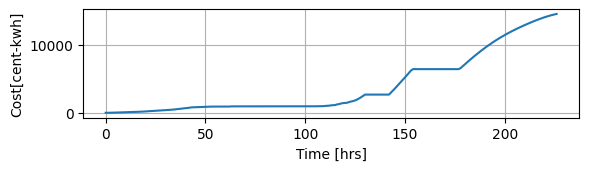

In [6]:
import matplotlib.pyplot as plt

plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [7]:
cumulativeCost[-1]

14503.880755950859

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

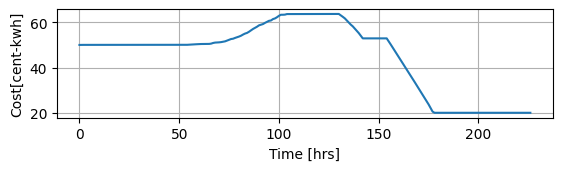

In [8]:
import matplotlib.pyplot as plt

plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot((Phydro / H2ToalE) * 100)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

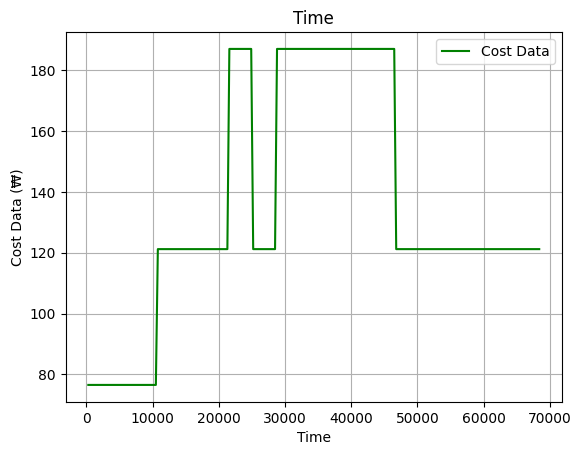

In [4]:
import matplotlib.pyplot as plt

# 시간 vs 태양광 데이터
plt.plot(time, costData, label='Cost Data', color='green')
plt.xlabel('Time')
plt.ylabel('Cost Data (₩)')
plt.title('Time')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
time[0:227]

array([[  300],
       [  600],
       [  900],
       [ 1200],
       [ 1500],
       [ 1800],
       [ 2100],
       [ 2400],
       [ 2700],
       [ 3000],
       [ 3300],
       [ 3600],
       [ 3900],
       [ 4200],
       [ 4500],
       [ 4800],
       [ 5100],
       [ 5400],
       [ 5700],
       [ 6000],
       [ 6300],
       [ 6600],
       [ 6900],
       [ 7200],
       [ 7500],
       [ 7800],
       [ 8100],
       [ 8400],
       [ 8700],
       [ 9000],
       [ 9300],
       [ 9600],
       [ 9900],
       [10200],
       [10500],
       [10800],
       [11100],
       [11400],
       [11700],
       [12000],
       [12300],
       [12600],
       [12900],
       [13200],
       [13500],
       [13800],
       [14100],
       [14400],
       [14700],
       [15000],
       [15300],
       [15600],
       [15900],
       [16200],
       [16500],
       [16800],
       [17100],
       [17400],
       [17700],
       [18000],
       [18300],
       [18600],
       [